In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
import torch.nn as nn
import torch.nn.functional as F
#dropout_value = 0.1

class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    
    self.convblock1= nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3),bias=False, padding=1, padding_mode='same'), # RF 3
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=16, out_channels=32 , kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #RF 5
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #RF 7
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), # RF 9
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),bias=False, padding=1, padding_mode='same'), #RF 11
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Dropout2d(0.1)
    ) # output_Size = 32
    
    self.transblock1= nn.Sequential(
        nn.MaxPool2d(2,2), #RF 12
        nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1,1), bias=False)
    )  # output_Size = 16
    
    self.convblock2= nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #RF 16
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #RF 20
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), bias=False, padding=1, groups=128, padding_mode='same'), #RF 24
        nn.BatchNorm2d(256),
        nn.ReLU(), 
        nn.Dropout2d(0.1)
    )  # output_Size = 16
    
    self.transblock2= nn.Sequential(
        nn.MaxPool2d(2,2), #26
        nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1,1), bias=False)
    )     # output_Size = 8
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #RF 34
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #RF 42
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), bias=False, padding=1, padding_mode='same',dilation=2), #RF 42
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), bias=False, padding=1,groups=128, padding_mode='same'), #RF 50
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Dropout2d(0.1)
    )  # output_Size = 6
    
    self.transblock3= nn.Sequential(
        nn.MaxPool2d(2,2), #RF 54
        nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1,1), bias=False)
    )  # output_Size = 3

    self.convblock4=nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),bias=False, padding=1, padding_mode='same'), #66
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(3),  # RF 74
        nn.Conv2d(in_channels=64,out_channels=10, kernel_size=(1,1),bias=False)
    )  # output_Size = 1 as 10 Classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    
    
  def forward(self, x):
      x=self.convblock1(x)
      x=self.transblock1(x)
      x=self.convblock2(x)
      x=self.transblock2(x)
      x=self.convblock3(x)
      x=self.transblock3(x)
      x=self.convblock4(x)
      x=x.view(-1,10)
      return x
model = Net()


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         Dropout2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


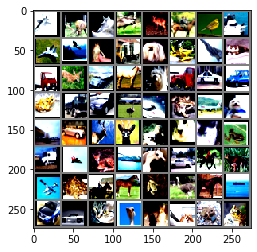

plane  deer horse  bird


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    regularization_loss = 0
    for param in model.parameters():
        regularization_loss += torch.sum(abs(param))
    classify_loss = criterion(y_pred,target)

    #loss = F.nll_loss(y_pred, target)
    factor = 0.0005
    loss = classify_loss + factor * regularization_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))



In [0]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [0]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
outputs = net(images)

In [0]:
import torch.optim as optim

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)


EPOCHS = 40

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=8.676328659057617 Batch_id=781 Accuracy=24.80: 100%|██████████| 782/782 [00:39<00:00, 20.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -1.1786, Accuracy: 3187/10000 (31.87%)

EPOCH: 1


Loss=7.297122001647949 Batch_id=781 Accuracy=36.43: 100%|██████████| 782/782 [00:39<00:00, 21.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -1.9075, Accuracy: 4519/10000 (45.19%)

EPOCH: 2


Loss=5.982760906219482 Batch_id=781 Accuracy=43.26: 100%|██████████| 782/782 [00:39<00:00, 21.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -2.4026, Accuracy: 5331/10000 (53.31%)

EPOCH: 3


Loss=4.911389350891113 Batch_id=781 Accuracy=50.11: 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -2.9673, Accuracy: 6159/10000 (61.59%)

EPOCH: 4


Loss=4.51737117767334 Batch_id=781 Accuracy=55.64: 100%|██████████| 782/782 [00:39<00:00, 19.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -3.3668, Accuracy: 6426/10000 (64.26%)

EPOCH: 5


Loss=3.5993247032165527 Batch_id=781 Accuracy=59.43: 100%|██████████| 782/782 [00:39<00:00, 21.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -3.8501, Accuracy: 6684/10000 (66.84%)

EPOCH: 6


Loss=3.80161452293396 Batch_id=781 Accuracy=62.08: 100%|██████████| 782/782 [00:39<00:00, 19.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.0378, Accuracy: 7070/10000 (70.70%)

EPOCH: 7


Loss=3.358914852142334 Batch_id=781 Accuracy=63.95: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.2492, Accuracy: 7186/10000 (71.86%)

EPOCH: 8


Loss=3.343596935272217 Batch_id=781 Accuracy=65.58: 100%|██████████| 782/782 [00:39<00:00, 19.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.5087, Accuracy: 7305/10000 (73.05%)

EPOCH: 9


Loss=2.7332820892333984 Batch_id=781 Accuracy=66.42: 100%|██████████| 782/782 [00:39<00:00, 21.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.5038, Accuracy: 7402/10000 (74.02%)

EPOCH: 10


Loss=2.871178150177002 Batch_id=781 Accuracy=66.88: 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.6673, Accuracy: 7171/10000 (71.71%)

EPOCH: 11


Loss=2.9625673294067383 Batch_id=781 Accuracy=67.27: 100%|██████████| 782/782 [00:39<00:00, 19.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.7865, Accuracy: 7509/10000 (75.09%)

EPOCH: 12


Loss=3.079355239868164 Batch_id=781 Accuracy=68.11: 100%|██████████| 782/782 [00:39<00:00, 19.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.5922, Accuracy: 7403/10000 (74.03%)

EPOCH: 13


Loss=2.837707757949829 Batch_id=781 Accuracy=68.38: 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.8463, Accuracy: 7361/10000 (73.61%)

EPOCH: 14


Loss=2.9305830001831055 Batch_id=781 Accuracy=68.56: 100%|██████████| 782/782 [00:39<00:00, 19.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.5807, Accuracy: 7347/10000 (73.47%)

EPOCH: 15


Loss=3.031003475189209 Batch_id=781 Accuracy=69.04: 100%|██████████| 782/782 [00:40<00:00, 19.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.0965, Accuracy: 7711/10000 (77.11%)

EPOCH: 16


Loss=2.7843692302703857 Batch_id=781 Accuracy=69.23: 100%|██████████| 782/782 [00:41<00:00, 18.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.0626, Accuracy: 7096/10000 (70.96%)

EPOCH: 17


Loss=2.775792121887207 Batch_id=781 Accuracy=69.43: 100%|██████████| 782/782 [00:41<00:00, 18.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.0480, Accuracy: 7579/10000 (75.79%)

EPOCH: 18


Loss=2.8935768604278564 Batch_id=781 Accuracy=69.73: 100%|██████████| 782/782 [00:41<00:00, 18.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.1537, Accuracy: 7555/10000 (75.55%)

EPOCH: 19


Loss=2.493177652359009 Batch_id=781 Accuracy=69.93: 100%|██████████| 782/782 [00:41<00:00, 18.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.2655, Accuracy: 7470/10000 (74.70%)

EPOCH: 20


Loss=3.104778289794922 Batch_id=781 Accuracy=70.24: 100%|██████████| 782/782 [00:41<00:00, 18.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.4456, Accuracy: 7564/10000 (75.64%)

EPOCH: 21


Loss=2.9004716873168945 Batch_id=781 Accuracy=70.46: 100%|██████████| 782/782 [00:41<00:00, 18.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.5251, Accuracy: 7582/10000 (75.82%)

EPOCH: 22


Loss=2.1988754272460938 Batch_id=781 Accuracy=70.55: 100%|██████████| 782/782 [00:40<00:00, 19.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.1072, Accuracy: 7799/10000 (77.99%)

EPOCH: 23


Loss=3.4023633003234863 Batch_id=781 Accuracy=71.07: 100%|██████████| 782/782 [00:39<00:00, 20.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.3246, Accuracy: 7719/10000 (77.19%)

EPOCH: 24


Loss=2.4592528343200684 Batch_id=781 Accuracy=71.20: 100%|██████████| 782/782 [00:39<00:00, 19.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.7321, Accuracy: 7580/10000 (75.80%)

EPOCH: 25


Loss=2.3974876403808594 Batch_id=781 Accuracy=71.11: 100%|██████████| 782/782 [00:39<00:00, 21.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.7125, Accuracy: 7753/10000 (77.53%)

EPOCH: 26


Loss=2.267003297805786 Batch_id=781 Accuracy=71.13: 100%|██████████| 782/782 [00:40<00:00, 19.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.5034, Accuracy: 7737/10000 (77.37%)

EPOCH: 27


Loss=2.3720836639404297 Batch_id=781 Accuracy=71.21: 100%|██████████| 782/782 [00:39<00:00, 19.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.6334, Accuracy: 7695/10000 (76.95%)

EPOCH: 28


Loss=2.4338479042053223 Batch_id=781 Accuracy=71.52: 100%|██████████| 782/782 [00:39<00:00, 20.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.6288, Accuracy: 7813/10000 (78.13%)

EPOCH: 29


Loss=2.6834018230438232 Batch_id=781 Accuracy=71.65: 100%|██████████| 782/782 [00:39<00:00, 19.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.7825, Accuracy: 7707/10000 (77.07%)

EPOCH: 30


Loss=2.7971811294555664 Batch_id=781 Accuracy=72.03: 100%|██████████| 782/782 [00:39<00:00, 20.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.8739, Accuracy: 7904/10000 (79.04%)

EPOCH: 31


Loss=2.63866925239563 Batch_id=781 Accuracy=71.73: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.7704, Accuracy: 7750/10000 (77.50%)

EPOCH: 32


Loss=2.689934730529785 Batch_id=781 Accuracy=72.13: 100%|██████████| 782/782 [00:39<00:00, 19.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.8978, Accuracy: 7905/10000 (79.05%)

EPOCH: 33


Loss=2.536736488342285 Batch_id=781 Accuracy=71.95: 100%|██████████| 782/782 [00:39<00:00, 19.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.8456, Accuracy: 7778/10000 (77.78%)

EPOCH: 34


Loss=2.4782333374023438 Batch_id=781 Accuracy=72.33: 100%|██████████| 782/782 [00:39<00:00, 20.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.9757, Accuracy: 7691/10000 (76.91%)

EPOCH: 35


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.7027, Accuracy: 7639/10000 (76.39%)

EPOCH: 36


Loss=2.9602649211883545 Batch_id=781 Accuracy=72.58: 100%|██████████| 782/782 [00:39<00:00, 19.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.9970, Accuracy: 7871/10000 (78.71%)

EPOCH: 37


Loss=2.204596996307373 Batch_id=781 Accuracy=72.42: 100%|██████████| 782/782 [00:39<00:00, 21.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.9857, Accuracy: 7786/10000 (77.86%)

EPOCH: 38


Loss=2.1211647987365723 Batch_id=781 Accuracy=72.60: 100%|██████████| 782/782 [00:39<00:00, 20.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -6.0544, Accuracy: 8007/10000 (80.07%)

EPOCH: 39


Loss=2.24240779876709 Batch_id=781 Accuracy=72.44: 100%|██████████| 782/782 [00:39<00:00, 20.89it/s]



Test set: Average loss: -6.2204, Accuracy: 7899/10000 (78.99%)



Submitted By Uday Kiran G & Srilakshmi V 